#### WRF QGPV perturbation inversion calculation

based on v5 of full inversion

works 14 March 2021

In [1]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import netCDF4
from netCDF4 import Dataset
from wrf import tk, to_np, getvar, CoordPair, destagger, smooth2d, interplevel, vinterp, ll_to_xy, latlon_coords,get_cartopy
import time

In [2]:
wrfout_fname = 'march_2020_wrfout.nc'  # trajectory output

wrfout = Dataset(wrfout_fname, 'r')  # Dataset is the class behavior to open the file

In [3]:
msfm = wrfout.variables['MAPFAC_M'][0, :, :]     # Map scale factor on mass grid
cor = wrfout.variables['F'][0,:, :]     # Coriolis parameter
ds = 1./wrfout.variables['RDX'][0]     # grid spacing SAME IN ZONAL AND MERIDIONAL DIRECTIONS
from wrf import smooth2d,extract_times
ti = 21
# Get the latitude and longitude points# Get the sea level pressure
slp = getvar(wrfout, "slp", timeidx=ti)
lats, lons = latlon_coords(slp)

jlen = slp.shape[0]
ilen = slp.shape[1]
for j in range(jlen):
    for i in range(ilen):
        if lons[j,i] < 0.0:
            lons[j,i] = lons[j,i] + 360.
        else:
            lons[j,i] = lons[j,i]
# Get the cartopy mapping object
cart_proj = get_cartopy(slp)

In [4]:
itime = ti # select model time
model_time =extract_times(wrfout,itime)
print(model_time)
day_of_month=str(model_time)[8:10]
hour_of_day=str(model_time)[11:13]
from wrf import extract_times
# Create a clean datetime object for plotting based on time of Geopotential heights
valid = extract_times(wrfout, itime, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
vtime = valid.astype('datetime64[ms]').astype('O')
print(vtime)

2020-03-07T09:00:00.000000000
2020-03-07 09:00:00


In [5]:
from standard_atmosphere import standard_atmosphere
pb = 1000.
pb_half = 975.
pt = 100.
pt_half = 125.
p_levels = np.linspace(pb,pt,19)
p_half_levels = np.linspace(pb_half,pt_half,18)

ZS,phiS,TS,SS=standard_atmosphere(p_levels, p_half_levels)

In [6]:
# Geopotential height
z = getvar(wrfout, "z", units="m", timeidx=ti)
z_full = vinterp(wrfout, z, 'pressure', p_levels, extrapolate=True, field_type='z', log_p=True, timeidx=ti,meta=False)
mean_hght=np.load('mean_hght.npz')
#mean_hght=np.load('mean_hght.npz')

zprime_mean = mean_hght['data']

In [7]:
from geovort import geostrophic_vorticity

num_lats=lats.shape[0]
num_lons=lons.shape[1]
num_levs=p_levels.size

g=9.8066

f0 = np.average(cor)
phi_prime=np.zeros([p_levels.size,num_lats,num_lons])

for k in np.arange(1,num_levs-1):
    phi_prime[k,:]=g*(z_full[k,:]-ZS[k]-zprime_mean[k,:])
    
qgpv_geovor=geostrophic_vorticity(num_levs,num_lats,num_lons,msfm,ds,f0,phi_prime)

In [8]:
def stretching_term(num_levs,num_lats,num_lons,msfm,ds,dp,f0,S,phip):

    AC_3s=np.zeros([num_levs])
    AC_6=np.zeros([num_levs])
    AC_7=np.zeros([num_levs]) 
    
    for k in np.arange(1,18):
        AC_6[k]=f0/(S[k-1]*dp**2.)
        AC_7[k]=f0/(S[k]  *dp**2.)
        AC_3s[k]= -(AC_6[k]+AC_7[k])
    strat=np.zeros([num_levs,num_lats,num_lons])
    
    for k in np.arange(1,num_levs-1):
        for j in np.arange(1,num_lats-1):
            for i in np.arange(1,num_lons-1):
                strat[k,j,i] = AC_3s[k]*phip[k,j,i]+ AC_6[k]*phip[k-1,j,i]+ AC_7[k]*phip[k+1,j,i]
    return strat

In [9]:
dp = 50.e2


mean_hght=np.load('mean_hght.npz')
#mean_hght=np.load('mean_hght.npz')

zprime_mean = mean_hght['data']

Tb=np.zeros([num_lats,num_lons])
Tt=np.zeros([num_lats,num_lons])

dz_b=np.zeros([num_lats,num_lons])
dz_t=np.zeros([num_lats,num_lons])

R=287.04
p=p_levels

z_prime = np.zeros([num_levs,num_lats,num_lons])

for k in range(p_levels.size):
    z_prime[k,:] = z_full[k,:]-ZS[k]-zprime_mean[k,:]


dz_b = (z_prime[1,:]-z_prime[0,:])
dz_t = (z_prime[-1,:]-z_prime[-2,:])

Tb = ((g*dz_b)/R)/np.log(p[0]/p[1])
Tt = ((g*dz_t)/R)/np.log(p[-2]/p[-1])

dp = 50.e2
phi_prime[0,:] = phi_prime[1,:] - (R * Tb[:]/(100*p_levels[0]))*dp
phi_prime[-1,:] = phi_prime[-2,:] + (R * Tt[:]/(100.*p_levels[-1]))*dp

The QGPV to be inverted is that QGPV calculated using the phi_pert = g((Z_full-Z_ref)- (z_mean-Zref)). check to see if zmean has z_ref alread subtracted from it.

In [10]:
qgpv_strtch = stretching_term(num_levs,num_lats,num_lons,msfm,ds,dp,f0,SS,phi_prime)
qgpv = qgpv_geovor + qgpv_strtch


qgpv_anomaly = np.zeros([num_levs,num_lats,num_lons])
for k in np.arange(9,12):
    qgpv_anomaly[k,:] = qgpv[k,:]
qgpv_anomaly.shape

(19, 143, 209)

In [11]:
%%time
from qgpv_invert import qgpv_invert
#
omega = 1.8
iterations=200
threshold = 1.

BC =np.zeros([p_levels.size,num_lats,num_lons])
res=np.zeros([p_levels.size,num_lats,num_lons])

#qgpv_anomaly = np.zeros([p_levels.size,num_lats,num_lons])
#for k in range(p_levels.size):
#    BC[k,:]=9.81*(z_full[k,:]-ZS[k])
BC_flag=1
Tb=np.zeros([num_lats,num_lons])
Tt=np.zeros([num_lats,num_lons])

phip=np.zeros([p_levels.size,num_lats,num_lons])

phip,res,num_iter=qgpv_invert(omega,iterations,threshold,p_levels,num_levs,num_lats,num_lons,f0, ds, dp,msfm,SS,qgpv_anomaly, Tb, Tt, BC, BC_flag)

stopping at iteration number:  180
error, num_levs*num_lats*num_lons:  180 567853
CPU times: user 14min 52s, sys: 3.79 s, total: 14min 56s
Wall time: 14min 58s


In [12]:
print("Number of iterations: ", num_iter+1)
print("Average residual: ", np.mean(res))  
print("Absolute maximum residual: ", np.amax(res))

Number of iterations:  181
Average residual:  -0.01662517736682977
Absolute maximum residual:  0.9932936503779786


/Users/mcmorgan/miniconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


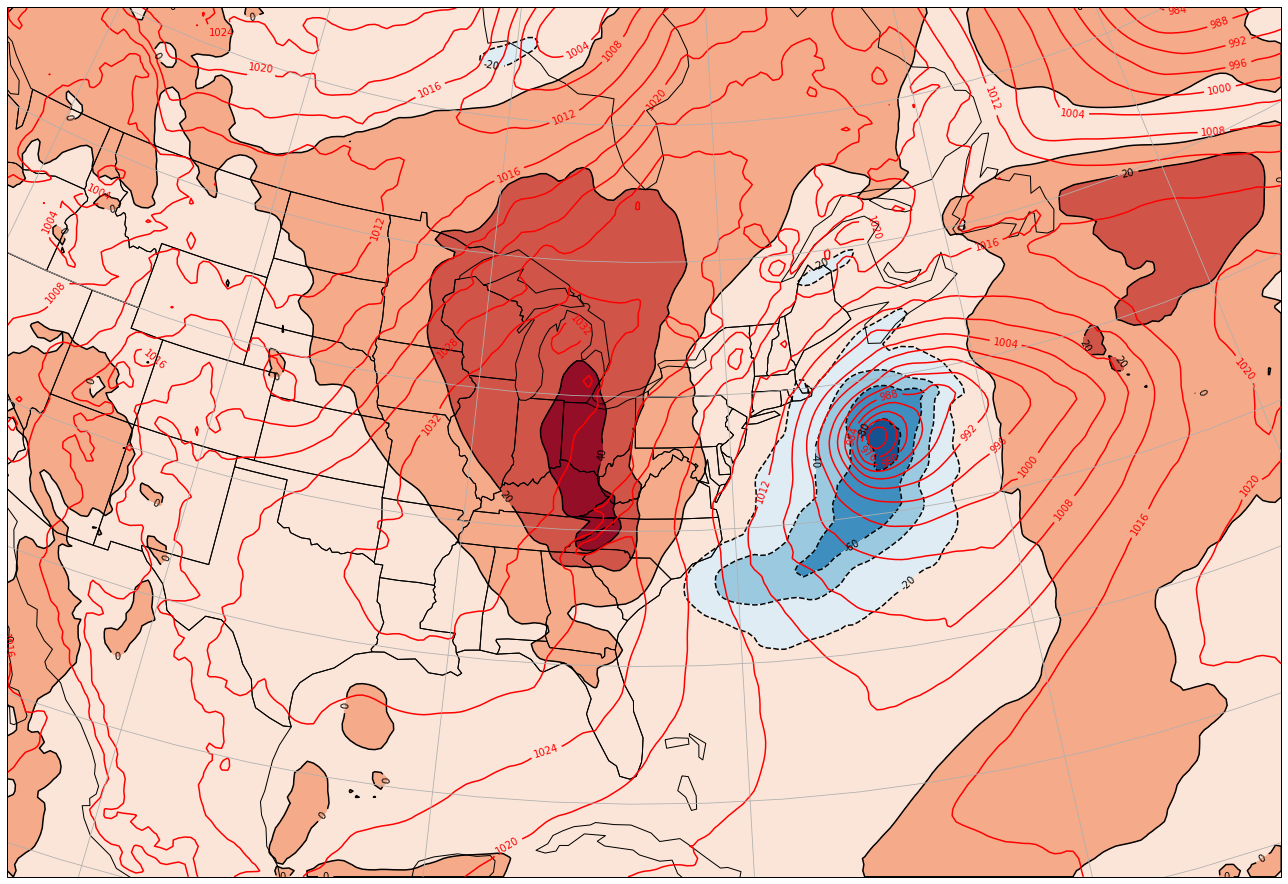

In [13]:
###%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


theta = getvar(wrfout, "theta", timeidx=ti)
thta = vinterp(wrfout, theta, 'pressure', p_levels, extrapolate=True, timeidx=ti)

fig = plt.figure(figsize=(24, 16))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)


#ax.contourf(lons, lats,phip[9,:]/g,cmap='RdBu_r',levels = np.arange(-300,315,10),transform=ccrs.PlateCarree())
ax.contourf(lons, lats,phip[1,:]/g,cmap='RdBu_r',transform=ccrs.PlateCarree())

#CS=ax.contour(lons,lats,phip[10,:]/g,colors='black',levels = np.arange(-300,315,15), transform=ccrs.PlateCarree())
CS=ax.contour(lons,lats,phip[1,:]/g,colors='black', transform=ccrs.PlateCarree())

#CS=ax.contour(lons,lats,np.average(thta[0:2,:],axis=0),colors='purple',levels=np.arange(270,296,3),transform=ccrs.PlateCarree())

#CS=ax.contour(lons, lats,to_np(z_full[0,:]), levels = np.arange(600,13200,120), transform=ccrs.PlateCarree())
#CS=ax.contour(lons, lats,to_np(z_full[10,:]), levels = np.arange(600,13200,60),transform=ccrs.PlateCarree(),colors='grey')

#ax.contour(lons, lats,PHI[10,:]-phip[10,:],transform=ccrs.PlateCarree(),colors='grey')

#ax.contour(lons, lats,qgpv_geovor[10,:]*1.e4,levels=(2,4,6,8),transform=ccrs.PlateCarree())
#CS = ax.contour(lons, lats,res[10,:],transform=ccrs.PlateCarree(),colors='blue')
#CS=ax.contour(lons, lats,Tb,transform=ccrs.PlateCarree())
#CS=ax.contour(lons, lats,np.average(qgpv_anomaly[1:7,:]*1.e5,axis=0),colors='red',transform=ccrs.PlateCarree())
CS_slp=ax.contour(lons, lats,slp,transform=ccrs.PlateCarree(),levels = np.arange(940,1040,4),colors='red')






ax.clabel(CS, CS.levels, inline=True,  fontsize=10,fmt='%.0f')
ax.clabel(CS_slp, CS_slp.levels, inline=True,  fontsize=10,fmt='%.0f')

#ax.set_extent([-150,-115,30,50])

# add some common geographic features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

# add some lat/lon gridlines
ax.gridlines()



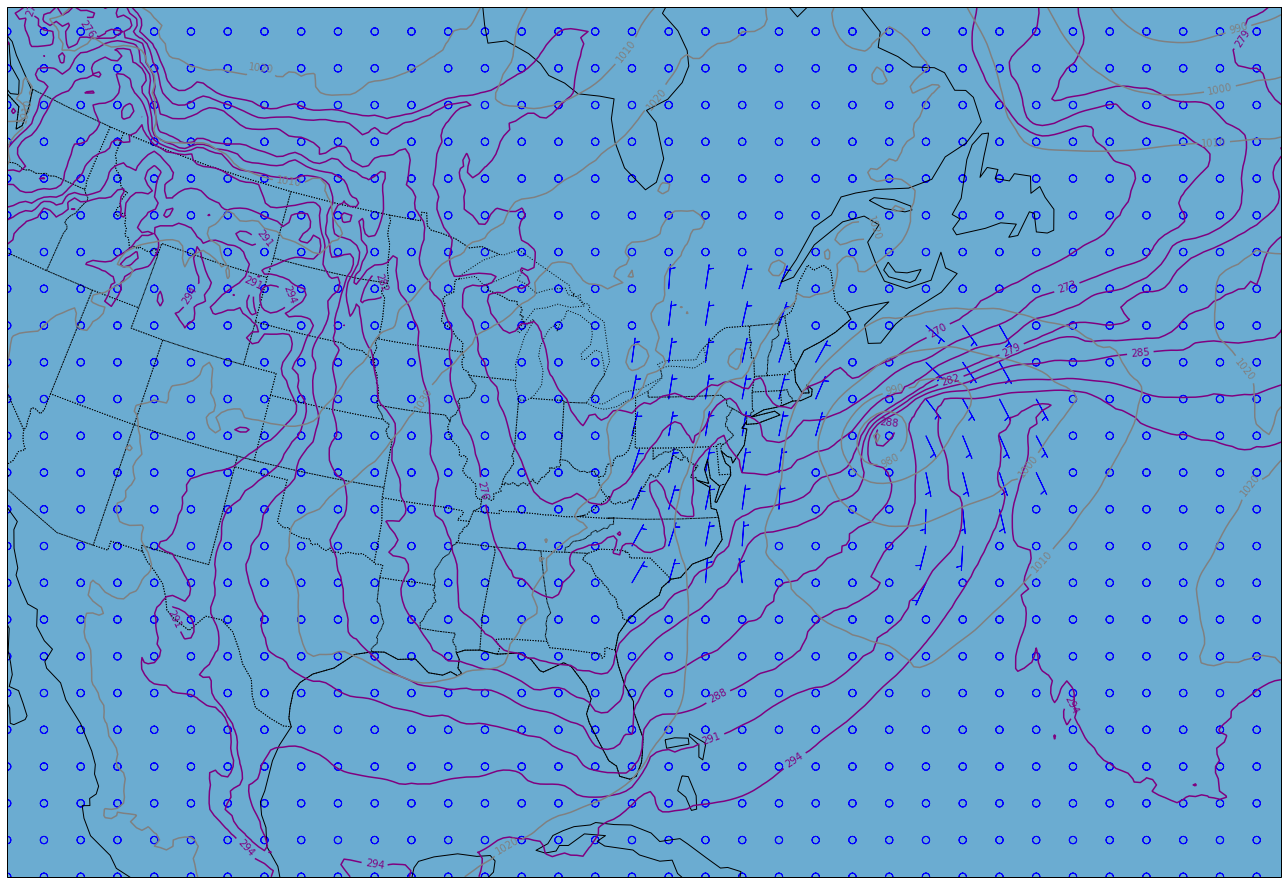

In [14]:
%matplotlib inline


fig = plt.figure(figsize=(24, 16))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS,linestyle=':')
ax.add_feature(cfeature.STATES,linestyle=':')

CS=ax.contour(lons,lats,np.average(thta[0:2,:],axis=0),colors='purple',levels=np.arange(270,296,3),transform=ccrs.PlateCarree())
CS_slp=ax.contour(lons, lats,slp,transform=ccrs.PlateCarree(),colors='grey')
ax.contourf(lons,lats,Tb,cmap='RdBu_r',transform=ccrs.PlateCarree())

ax.clabel(CS, CS.levels, inline=True,  fontsize=10,fmt='%.0f')
ax.clabel(CS_slp, CS_slp.levels, inline=True,  fontsize=10,fmt='%.0f')


#calculate winds
U= np.zeros([num_lats,num_lons])
V=np.zeros([num_lats,num_lons])

ilev=1
SCALE = 1
for j in np.arange(1,num_lats-1):
    U[j,:] = -msfm[j,:]*0.5*(phip[ilev,j+1,:]-phip[ilev,j-1,:])/(f0*ds)

for i in np.arange(1,num_lons-1):
    V[:,i] =  msfm[:,i]*0.5*(phip[ilev,:,i+1]-phip[ilev,:,i-1])/(f0*ds)


quiver_slices = (slice(None, None, 6), slice(None, None, 6))
quiver_kwargs = {'headlength': 4, 'headwidth': 3,
                 'scale': 100}
#ax.set_extent([-160,-115,30,55])
#ax.quiver(to_np(lons[quiver_slices]),to_np(lats[quiver_slices]), \
#    U[::7,::7]*SCALE, V[::7,::7]*SCALE,color='blue',\
#    transform=ccrs.PlateCarree(),**quiver_kwargs)
ax.barbs(to_np(lons[quiver_slices]),to_np(lats[quiver_slices]), \
    U[::6,::6]*SCALE, V[::6,::6]*SCALE,color='blue',\
    transform=ccrs.PlateCarree(),length=7,barb_increments=dict(half=5, full=10, flag=50))
plt.savefig('inversion_of_Tb_at_surface_for_time_F6')
plt.show()

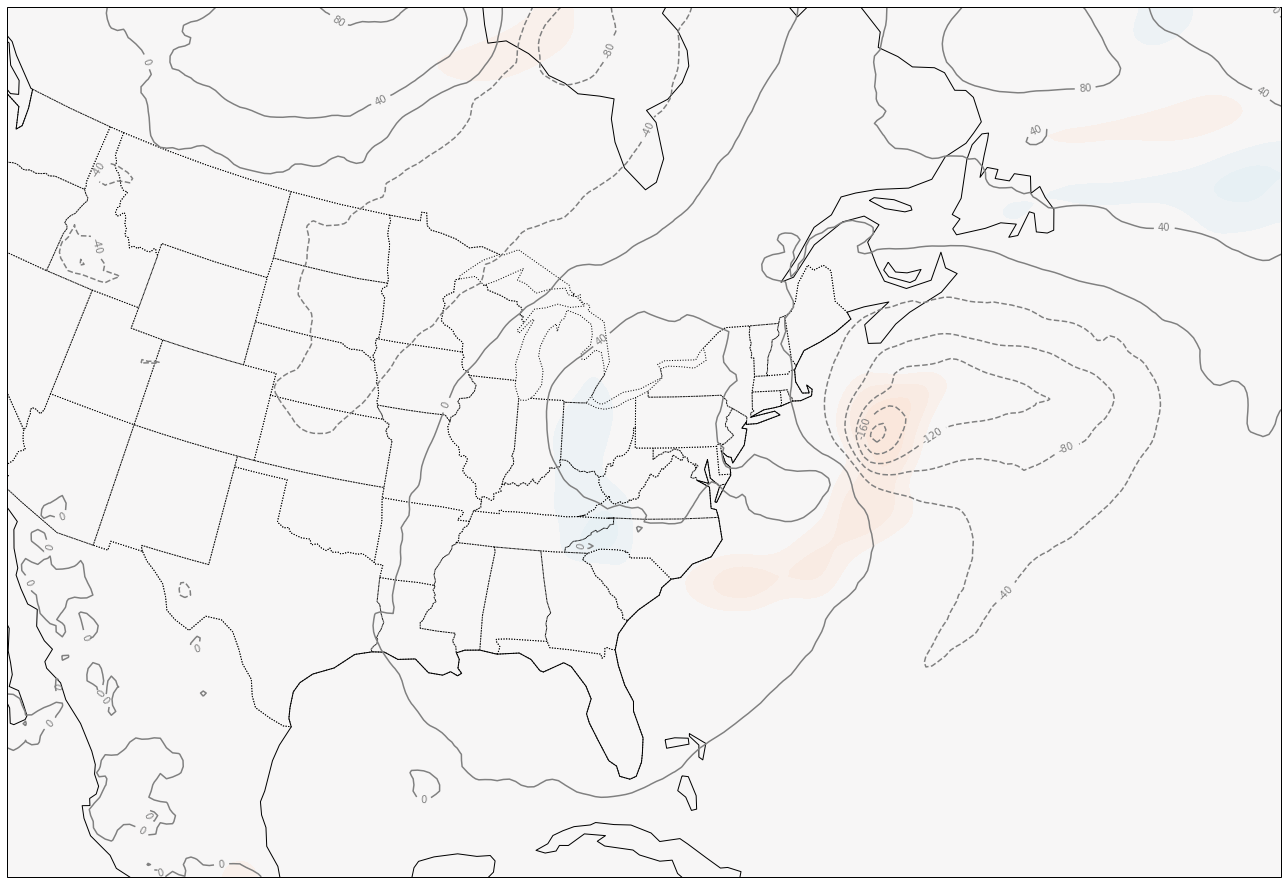

In [15]:
%matplotlib inline

from scipy.ndimage.filters import gaussian_filter

fig = plt.figure(figsize=(24, 16))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS,linestyle=':')
ax.add_feature(cfeature.STATES,linestyle=':')

levels = np.arange(-150,155,5)
CS=ax.contourf(lons,lats,gaussian_filter(np.mean(qgpv_anomaly[7:13,:]*1.e5,axis=0), 3),levels=levels[(levels < -0.01)|(levels>0.01)],cmap='RdBu_r',transform=ccrs.PlateCarree())
CS_slp=ax.contour(lons, lats,z_prime[0,:],transform=ccrs.PlateCarree(),colors='grey')
#ax.contourf(lons,lats,Tb,cmap='RdBu_r',transform=ccrs.PlateCarree())

#ax.clabel(CS, CS.levels, inline=True,  fontsize=10,fmt='%.0f')
ax.clabel(CS_slp, CS_slp.levels, inline=True,  fontsize=10,fmt='%.0f')


plt.savefig('inversion_of_Tb_at_surface_for_time_F6')
plt.show()

In [16]:
print(np.min(to_np(slp[50:-1,100:-1])))
np.where(to_np(slp)==994.0648)
#86,162

969.4130424128663


(array([], dtype=int64), array([], dtype=int64))

In [17]:
np.max(sqrt(U**2+V**2))

3.965551489434616